### Explore Data

In [1]:
import numpy as np
import librosa
from librosa import display

In [2]:
y, sr = librosa.load("genres/classical/classical.00000.wav")
hop_length = 512
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

In [3]:
print(mfcc.shape)
print(mfcc.flatten().shape)

(13, 1293)
(16809,)


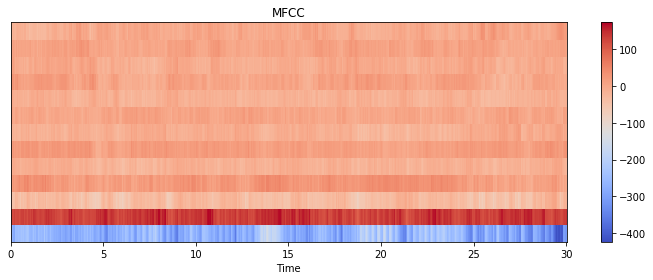

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

### Load Data

In [6]:
all_genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
num_songs = 100
Y_LIMIT = 660000

In [7]:
# Loads n_songs songs from each genre in load_genres.  
def load_dataset(genres=all_genres, n_songs=num_songs):
    X, Y = None, None
    for g_idx, g in enumerate(genres):
        for s_idx in range(n_songs):
            y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.wav')
            # Limit length of sample so that all features have the same length.
            y = y[:Y_LIMIT]
            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13).flatten()
            
            if X is None:
                X = mfcc.reshape(1, mfcc.shape[0])
                Y = np.array([[g_idx]])
                
            else:
                X = np.vstack([X, mfcc])
                Y = np.vstack([Y, np.array([[g_idx]])])
    return X, Y

In [8]:
X, Y = load_dataset(all_genres, 100)
Y = Y.ravel()

In [9]:
print(X.shape, Y.shape)

(1000, 16770) (1000,)


# Models

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,\
    cross_val_score, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X[0]

array([-0.5440791 , -0.5192269 , -0.32152832, ...,  0.5927453 ,
        0.80659366,  0.6059533 ], dtype=float32)

In [12]:
def plot_confusion_matrix(test_labels, predictions, title):
    ax= plt.subplot()
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, ax = ax, cmap = sns.cm.rocket_r); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'{title} Confusion Matrix'); 
    ax.set_ylim(top=0, bottom=10)
    ax.xaxis.set_ticklabels(all_genres); ax.yaxis.set_ticklabels(all_genres);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.show()

### SVM

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y) 

In [14]:
from sklearn.svm import SVC

In [15]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [.1, 1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [17]:
params_grid = [{'kernel': ['linear'], 'C': [1, 10]}]

In [18]:
svm_model = GridSearchCV(SVC(), params_grid, iid = False, cv=3)
svm_model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=None,
             param_grid=[{'C': [1, 10], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")

final_model = svm_model.best_estimator_

Best score for training data: 0.517152551570553 

Best C: 1 

Best Kernel: linear 



In [20]:
svm_predictions = final_model.predict(X_test)

In [21]:
print(classification_report(y_test,svm_predictions))

              precision    recall  f1-score   support

           0       0.35      0.33      0.34        24
           1       0.76      0.85      0.80        26
           2       0.79      0.34      0.48        32
           3       0.44      0.50      0.47        22
           4       0.38      0.40      0.39        20
           5       0.50      0.74      0.60        31
           6       0.64      0.90      0.75        20
           7       0.53      0.80      0.64        20
           8       0.57      0.36      0.44        22
           9       0.25      0.15      0.19        33

    accuracy                           0.52       250
   macro avg       0.52      0.54      0.51       250
weighted avg       0.52      0.52      0.50       250



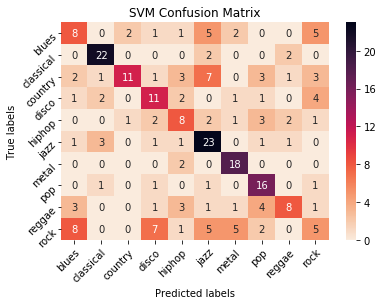

In [22]:
plot_confusion_matrix(y_test, svm_predictions, 'SVM')

### LR

In [266]:
from sklearn.linear_model import LogisticRegression

In [267]:
lr_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, Y) 

In [269]:
lr_model.fit(X_train, y_train)

/home/brendan/Workspace/6.867/yes/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [270]:
lr_accuracy = lr_model.score(X_test, y_test)
lr_accuracy

0.464

In [271]:
lr_predictions = lr_model.predict(X_test)

In [272]:
print(classification_report(y_test,lr_predictions))

              precision    recall  f1-score   support

           0       0.27      0.38      0.32        26
           1       0.68      0.88      0.76        24
           2       0.29      0.40      0.33        20
           3       0.21      0.21      0.21        19
           4       0.35      0.39      0.37        23
           5       0.52      0.48      0.50        25
           6       0.73      0.79      0.76        28
           7       0.77      0.59      0.67        34
           8       0.43      0.22      0.29        27
           9       0.25      0.17      0.20        24

    accuracy                           0.46       250
   macro avg       0.45      0.45      0.44       250
weighted avg       0.47      0.46      0.46       250



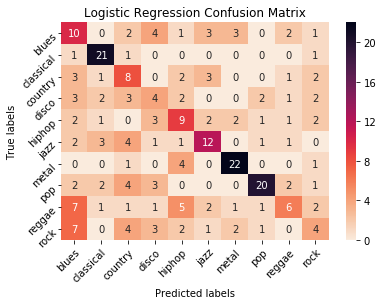

In [273]:
plot_confusion_matrix(y_test, lr_predictions, 'Logistic Regression')

### Random Forest

In [274]:
from sklearn.ensemble import RandomForestClassifier

In [275]:
rf_model = RandomForestClassifier(n_estimators=30)

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, Y) 

In [277]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [278]:
rf_accuracy = rf_model.score(X_test, y_test)
rf_accuracy

0.52

In [279]:
rf_predictions = rf_model.predict(X_test)

In [280]:
print(classification_report(y_test,rf_predictions))

              precision    recall  f1-score   support

           0       0.35      0.41      0.38        22
           1       0.52      0.89      0.65        19
           2       0.26      0.25      0.26        20
           3       0.71      0.39      0.50        31
           4       0.38      0.29      0.32        21
           5       0.73      0.52      0.60        31
           6       0.62      0.87      0.73        23
           7       0.58      0.89      0.70        35
           8       0.53      0.32      0.40        25
           9       0.35      0.26      0.30        23

    accuracy                           0.52       250
   macro avg       0.50      0.51      0.48       250
weighted avg       0.53      0.52      0.50       250



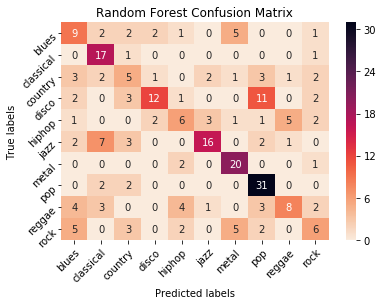

In [281]:
plot_confusion_matrix(y_test, rf_predictions, 'Random Forest')

### PCA

https://pythonprogramming.net/3d-scatter-plot-customizing/

https://python-graph-gallery.com/372-3d-pca-result/

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

https://pythonspot.com/3d-scatterplot/

In [23]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import axes3d

In [24]:
pca = PCA(n_components=3)
pca.fit(X_test)
projected = pca.transform(X_test)
print(X_test.shape)
print(projected.shape)

(250, 16770)
(250, 3)


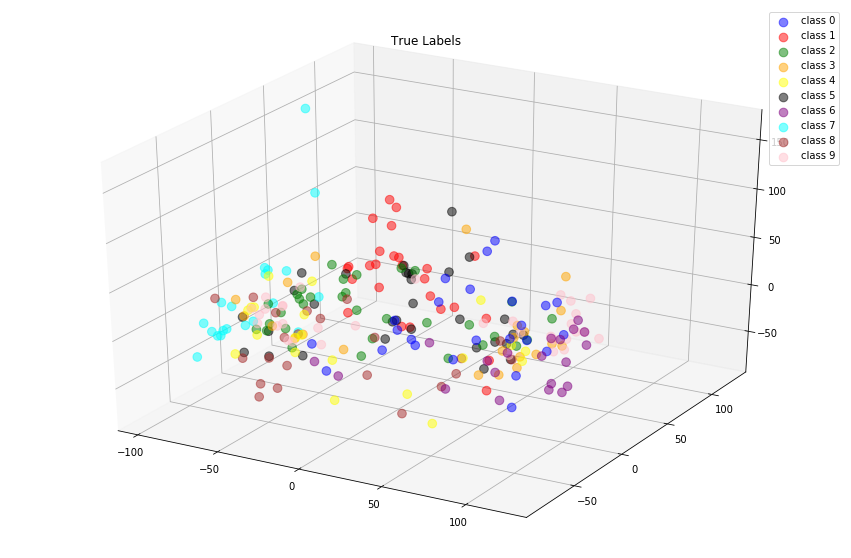

In [75]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for l, c in zip(range(0, 10),
                ('blue', 'red', 'green', 'orange', 'yellow', 'black', 'purple', 'cyan', 'brown', 'pink')):
    ax.scatter(projected[y_test == l, 0],
                projected[y_test == l, 1],
                projected[y_test == l, 2],
                color=c,
                label='class %s' % l,
                alpha=.5,
                marker=m,
                s=75
                )
plt.title('True Labels')
plt.xlabel=('PC1')
plt.ylabel=('PC2')
plt.zlabel=('PC3')
plt.grid()
plt.legend(loc='upper right')
plt.show()

TypeError: 'str' object is not callable

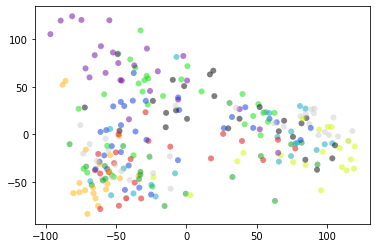

In [74]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel ('component 1')
# plt.ylabel('component 2')
plt.title('Actual')
plt.colorbar()
plt.grid()